one example about layer-feature extraction from: https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3


In [1]:

import torch
import torch.nn as nn
from torchvision import models

model = models.segmentation.fcn_resnet50(pretrained=True)
print(model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

<PIL.Image.Image image mode=RGB size=480x360 at 0x13A1EA34688>


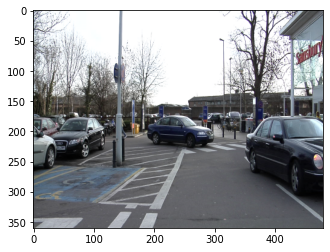

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

im = Image.open('.Data/CamVid/train/0006R0_f03450.png').convert("RGB")
print(im)
plt.imshow(im)

In [4]:
#preprocess

from torchvision import transforms, datasets, models
import cv2


data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

x = data_transform(im)
print(x.shape)
#print(x)



x = torch.transpose(x, 0,1)
x = torch.transpose(x, 1,2)
print(x.shape)

x= cv2.resize(x.numpy(), (64,64))
print(x.shape)

x= data_transform(x)
x = x[None,:,:,:]
print(x.shape)


torch.Size([3, 360, 480])
torch.Size([360, 480, 3])
(64, 64, 3)
torch.Size([1, 3, 64, 64])


torch.Size([1, 21, 64, 64])


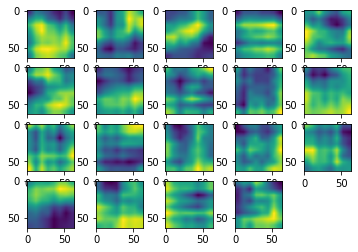

In [8]:
model.eval()
y = model(x)
print(y['out'].shape)


fig = plt.figure()
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(y['out'][0,i].detach().numpy())

In [15]:
#removing all classifier layers
model = models.segmentation.fcn_resnet50(pretrained=True)

new_classifier = nn.Sequential(*list(model.aux_classifier.children())[:0])
model.aux_classifier = new_classifier
model.classifier = new_classifier
print(model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [16]:
model.eval()
y = model(x)
print(y['out'].shape)

torch.Size([1, 2048, 64, 64])


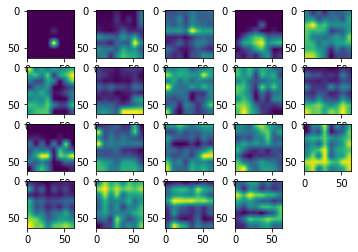

In [17]:
fig = plt.figure()
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(y['out'][0,i].detach().numpy())

FROM EXAMPLES

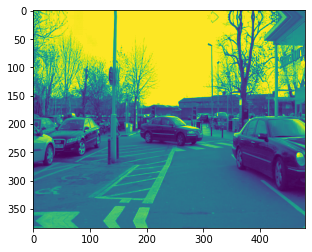

In [18]:
import albumentations as albu
import segmentation_models_pytorch as smp

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

test_transform = albu.PadIfNeeded(384, 480)
"""pytorch way to do that: 

pad = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(384,480), 
    ])"""


path  = '.Data/CamVid/train/0006R0_f03450.png'

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def preprocess(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    x = test_transform(image=image)
    x = preprocessing_fn(x['image'])
    x = to_tensor(x)
    plt.imshow(x[0])
    return x

x = preprocess(path)

In [20]:
fpn_model = torch.load('.models/best_model.pth')
fpn_model.eval()

FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

In [21]:
x_tensor = torch.from_numpy(x).unsqueeze(0)
x_tensor.shape

torch.Size([1, 3, 384, 480])

torch.Size([1, 1, 384, 480])


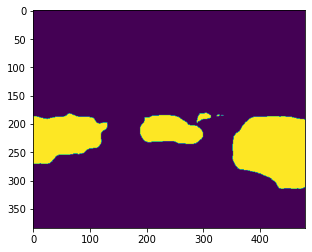

In [22]:
fpn_model.eval() #to stop training mod 
yy = fpn_model.predict(x_tensor)
print(yy.shape)

pr_mask = (yy.squeeze().numpy().round())

#plt.imshow(yy[0,0].detach().numpy())
plt.imshow(pr_mask)

8 November 20

In [24]:
import torch
import torch.nn as nn
from torchvision import models

#other way of extracting layers of weighted model

original_alex = models.alexnet(pretrained=True)

class AlexNetConv4(nn.Module):
            def __init__(self):
                super(AlexNetConv4, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_alex.features.children())[:-3]
                )
            def forward(self, x):
                x = self.features(x)
                return x

alex = AlexNetConv4()

In [26]:
print(alex)
print(original_alex)

AlexNetConv4(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
)
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=

UNET from pytorch.org

In [27]:
import torch
UNET = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to C:\Users\baran.tanriverdi/.cache\torch\hub\master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to C:\Users\baran.tanriverdi/.cache\torch\hub\checkpoints\unet-e012d006.pt


In [28]:
print(x.shape)
x = x.transpose(1, 2, 0).astype('float32')
X = cv2.resize(x, (32,32))
print(X.shape)

X = X.transpose(2, 0, 1).astype('float32')
print(X.shape)


(3, 384, 480)
(32, 32, 3)
(3, 32, 32)


torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])


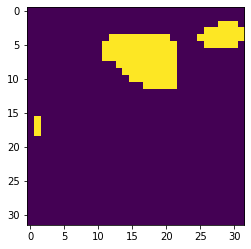

In [29]:
X_tensor = torch.from_numpy(X).unsqueeze(0)
print(X_tensor.shape)

Y = UNET(X_tensor)
pr_mask = (Y.detach().squeeze().numpy().round())
print(Y.shape)
plt.imshow(pr_mask)

UNET from our example

In [31]:
unet = torch.load('.models/best_unet_model.pth')
print(unet)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

torch.Size([1, 1, 384, 480])


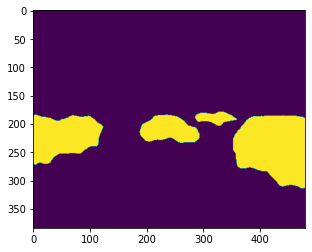

In [32]:
x = preprocess(path)

x_tensor = torch.from_numpy(x).unsqueeze(0)
x_tensor.shape

unet.eval()
yy = unet.predict(x_tensor)
print(yy.shape)

pr_mask = (yy.squeeze().numpy().round())

#plt.imshow(yy[0,0].detach().numpy())
plt.imshow(pr_mask)

SESSION 2

In [ ]:
#imports

import torch
import torch.nn as nn

from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms, datasets, models
import cv2
import time

import albumentations as albu
import segmentation_models_pytorch as smp

In [57]:
unet = torch.load('.models/best_unet_model.pth')
print(unet)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

torch.Size([1, 1, 384, 480])


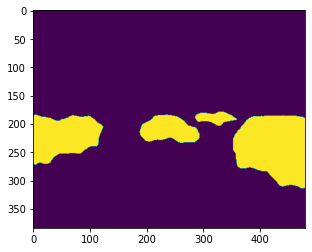

In [58]:
unet.eval()
yy = unet.predict(x_tensor)
print(yy.shape)

pr_mask = (yy.squeeze().numpy().round())

#plt.imshow(yy[0,0].detach().numpy())
plt.imshow(pr_mask)

In [59]:
remove_head = nn.Sequential(*list(unet.segmentation_head.children())[:0])
#remove_ = nn.Sequential(*list(unet.decoder.children())[0:][:4])
unet.segmentation_head = remove_head

print(unet)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

torch.Size([1, 16, 384, 480])


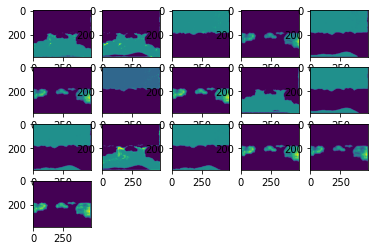

In [60]:
yy = unet.predict(x_tensor)
print(yy.shape)

pr_mask = (yy.squeeze().numpy().round())

fig = plt.figure()
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i-1])
    if i ==16: break

In [62]:
remove_decoder = nn.Sequential(*list(unet.decoder.blocks.children())[:4])
#remove_ = nn.Sequential(*list(unet.decoder.children())[0:][:4])
unet.decoder.blocks = remove_decoder

print(unet)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

torch.Size([1, 32, 192, 240])


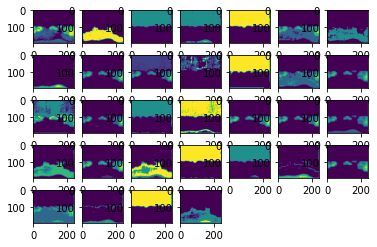

In [63]:
yy = unet.predict(x_tensor)
print(yy.shape)

pr_mask = (yy.squeeze().numpy().round())

fig = plt.figure()
for i in range(1,35):
    plt.subplot(5,7,i)
    plt.imshow(pr_mask[i-1])
    if i ==32: break

In [ ]:
#remove all decoder
remove_decoder = nn.Sequential(*list(unet.decoder.blocks.children())[:0])
#remove_ = nn.Sequential(*list(unet.decoder.children())[0:][:4])
unet.decoder.blocks = remove_decoder

print(unet)

torch.Size([1, 64, 192, 240])


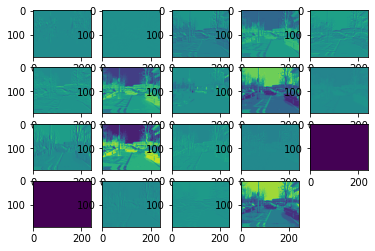

In [86]:
yy= unet.encoder.conv1(x_tensor)

print(yy.shape)

pr_mask = (yy.squeeze().detach().numpy().round())

for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i])

torch.Size([1, 3, 384, 480])
torch.Size([1, 64, 192, 240])
torch.Size([1, 64, 96, 120])
torch.Size([1, 128, 48, 60])
torch.Size([1, 256, 24, 30])
torch.Size([1, 512, 12, 15])


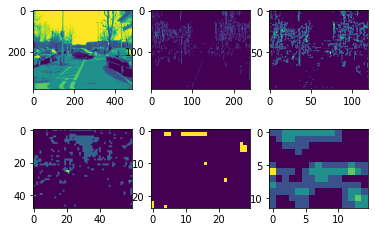

In [112]:
yy= unet.encoder(x_tensor)

for i in range(1,7):
    print(yy[i-1].shape)
    pr_mask = (yy[i-1].squeeze().detach().numpy().round())

    # bottleneck images' sample
    plt.subplot(2,3,i)
    plt.imshow(pr_mask[1])

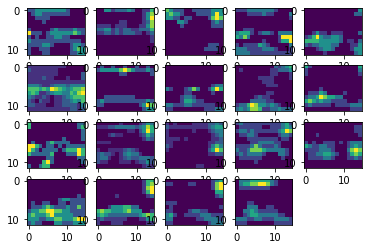

In [113]:
pr_mask = (yy[5].squeeze().detach().numpy().round())
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i])

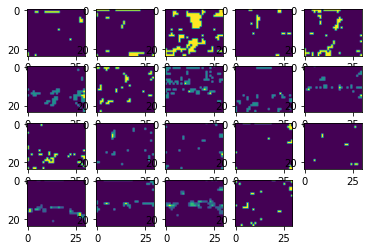

In [114]:
pr_mask = (yy[4].squeeze().detach().numpy().round())
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i])

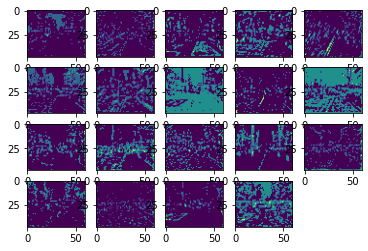

In [115]:
pr_mask = (yy[3].squeeze().detach().numpy().round())
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i])

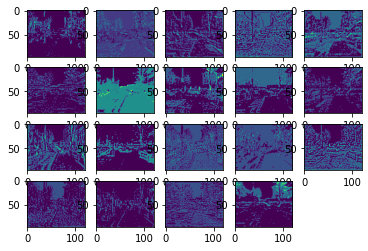

In [116]:
pr_mask = (yy[2].squeeze().detach().numpy().round())
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i])

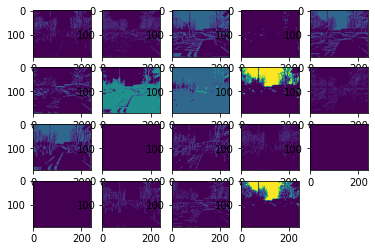

In [117]:
pr_mask = (yy[1].squeeze().detach().numpy().round())
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i])

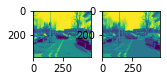

In [119]:
pr_mask = (yy[0].squeeze().detach().numpy().round())
for i in range(1,3):
    plt.subplot(4,5,i)
    plt.imshow(pr_mask[i])